# План

1. EDA
2. Дизайн А/Б-теста<br>
2.1 Определение метрик и гипотез<br>
2.2 Выбор подходящего стат. теста для метрик<br>
2.3 Уровень значимости (α), мощность (1 - β), длительность, размер выборки и MDE<br>
2.4 Разбиение на группы и А/А-тест
3. Ответы на вопросы

# 1. EDA

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as ss

import requests
from urllib.parse import urlencode

In [2]:
def get_download_url(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [3]:
df = pd.read_csv(get_download_url('https://disk.yandex.ru/d/gdXR2lcq7vVutg'),
                 sep=';',
                 parse_dates=['registration_date', 'activation_date'],
                 dayfirst=True)

df.head()

,registration_date,activation_date,merchant_id,type,ind_frod
0,2023-12-16,2023-12-24,1,IE,0.0
1,2023-09-05,2023-09-08,2,IE,0.0
2,2023-04-16,2023-04-22,3,IE,0.0
3,2023-12-23,2023-12-24,4,IE,0.0
4,2023-01-28,NaT,5,IE,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   registration_date  35000 non-null  datetime64[ns]
 1   activation_date    20300 non-null  datetime64[ns]
 2   merchant_id        35000 non-null  int64         
 3   type               35000 non-null  object        
 4   ind_frod           34300 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 1.3+ MB


Всего в датафрейме 35000 строк. Видим, что у `ind_frod` есть 700 пропусков, избавимся от этих данных.

In [5]:
df = df.query('ind_frod >= 0')

In [6]:
# Посмотрим на уникальность значений в датафрейме
df.nunique()

registration_date      365
activation_date        380
merchant_id          34300
type                     2
ind_frod                 2
dtype: int64

Видим, что все `merchant_id` уникальны, то есть наблюдения независимы между собой.

In [7]:
# Посмотрим, за какой временной период у нас есть данные в датафрейме по регистрациям
df.registration_date.min(), df.registration_date.max()

(Timestamp('1970-01-01 00:00:00'), Timestamp('2023-12-31 00:00:00'))

In [8]:
# Посмотрим на дату 01.01.1970
df.query('registration_date == "01.01.1970" and activation_date.notnull()').head()

,registration_date,activation_date,merchant_id,type,ind_frod
2392,1970-01-01,2023-02-18,2393,IE,1.0
3599,1970-01-01,2023-07-11,3600,IE,0.0
3773,1970-01-01,2023-03-05,3774,IE,0.0
4263,1970-01-01,2023-06-27,4264,IE,0.0
4740,1970-01-01,2023-04-01,4741,IE,1.0


In [9]:
# Посмотрим, сколько у нас наблюдений с датой 01.01.1970
df.query('registration_date == "01.01.1970" and activation_date.notnull()').shape[0]

85

Можно предположить, что 01.01.1970 - это данные за 1 января 2023 г., но это, скорее всего, неверно, так как даты активации таких юзеров с 01.01.1970 были достаточно далеко от даты регистрации. Скорее всего, произошел какой-то баг и некоторые даты регистраций мерчантов не записались, т. е. значение `registration_date` стало нулевым, а 0 — это как раз 01.01.1970 в Unix-формате. Избавимся от этих данных, так как далее, например, мы будем считать среднее кол-во регистраций в день, а эти пустые даты непонятно, к какому дню относятся, плюс таких наблюдений всего лишь 85.

In [10]:
df = df.query('registration_date != "01.01.1970"')

In [11]:
df.registration_date.min(), df.registration_date.max()

(Timestamp('2023-01-02 00:00:00'), Timestamp('2023-12-31 00:00:00'))

Видим, что теперь мы располагаем данными с 2 января по декабрь 2023 года вкл. Данные за 1 января у нас отсутствуют.

In [12]:
# Посмотрим, за какой временной период у нас есть данные в датафрейме по активациям.
df.activation_date.min(), df.activation_date.max()

(Timestamp('2022-01-22 00:00:00'), Timestamp('2024-08-30 00:00:00'))

In [13]:
# Посмотрим на наблюдения с датой активации в 2024 году
df.query('activation_date > "31.12.2023"').sort_values('activation_date', ascending=False).head()

,registration_date,activation_date,merchant_id,type,ind_frod
34890,2023-08-23,2024-08-30,34891,LLC,0.0
29939,2023-12-31,2024-01-11,29940,LLC,1.0
23723,2023-12-31,2024-01-11,23724,IE,0.0
23813,2023-12-30,2024-01-10,23814,IE,0.0
9272,2023-12-31,2024-01-10,9273,IE,0.0


Видим, что у нас есть одно аномальное наблюдение, где активация произошла примерно через год. Возможно, что произошел какой-то баг и 2023 год записался как 2024, это похоже на правду, так как дата активации наступила бы в таком случае через 7 дней. Заменим значение 2024 года на 2023 для этого наблюдения.

In [14]:
df.loc[34890,'activation_date'] = df.query('activation_date == "30.08.2024"').activation_date.map(lambda val: val.replace(year=2023)).values

In [15]:
df.loc[[34890]]

,registration_date,activation_date,merchant_id,type,ind_frod
34890,2023-08-23,2023-08-30,34891,LLC,0.0


In [16]:
df.activation_date.min(), df.activation_date.max()

(Timestamp('2022-01-22 00:00:00'), Timestamp('2024-01-11 00:00:00'))

Видим, что теперь мы располагаем данными с 22 января 2023 года по 11 января 2024 года вкл. Выглядит правдоподобно.

In [17]:
# Посмотрим, есть ли у нас наблюдения, где дата активации раньше, чем дата регистрации
df.query('activation_date < registration_date').head()

,registration_date,activation_date,merchant_id,type,ind_frod
16,2023-09-21,2023-08-27,17,IE,1.0
223,2023-07-02,2023-05-11,224,IE,0.0
670,2023-11-23,2023-11-04,671,IE,0.0
1007,2023-05-26,2022-06-03,1008,IE,0.0
1829,2023-05-24,2023-05-21,1830,IE,0.0


In [18]:
df.query('activation_date < registration_date').shape[0]

19

Такие наблюдения есть, избавимся от них, так как это выглядит нелогично и таких наблюдений всего 19.

Также создадим два новых датафрейма, чтобы было удобно работать с регистрациями и активациями. В `registration_df` будут все регистрации юзеров, как активированных, так и неактивированных (юзер отвалился, не захотел проходить остальные этапы регистрации), а в `activation_df` будут только активированные юзеры.

In [19]:
registration_df = df.query('activation_date >= registration_date or activation_date.isnull()')
registration_df.head()

,registration_date,activation_date,merchant_id,type,ind_frod
0,2023-12-16,2023-12-24,1,IE,0.0
1,2023-09-05,2023-09-08,2,IE,0.0
2,2023-04-16,2023-04-22,3,IE,0.0
3,2023-12-23,2023-12-24,4,IE,0.0
4,2023-01-28,NaT,5,IE,0.0


In [20]:
activation_df = df.query('activation_date >= registration_date')
activation_df.head()

,registration_date,activation_date,merchant_id,type,ind_frod
0,2023-12-16,2023-12-24,1,IE,0.0
1,2023-09-05,2023-09-08,2,IE,0.0
2,2023-04-16,2023-04-22,3,IE,0.0
3,2023-12-23,2023-12-24,4,IE,0.0
7,2023-10-27,2023-10-29,8,IE,0.0


In [21]:
activation_df.shape[0] / registration_df.shape[0] * 100

58.04210155975138

Видим, что из всех зарегистрированных юзеров только 58% прошли до конца регистрацию.

# 2. Дизайн А/Б-теста

## 2.1 Определение метрик и гипотез

В качестве метрик можно использовать следующие:
- основная - доля активированных фродеров среди всех активированных юзеров
- дополнительная - среднее кол-во регистраций в день

Соответственно, гипотезы будут звучать так:
- при внедрении модели по автоопределению продавцов-мошенников доля фродеров среди всех активированных юзеров уменьшится (для основной метрики)
- при внедрении ML-модели среднее кол-во регистраций в день не должно уменьшиться (для доп. метрики)

Для начала возьмем основную метрику - процент активированных фродеров среди всех активированных юзеров. Посмотрим, сколько у нас фродеров и честных продавцов среди активированных юзеров, то есть посчитаем их долю.

In [22]:
activation_df.groupby('ind_frod').ind_frod.count()

ind_frod
0.0    18198
1.0     1599
Name: ind_frod, dtype: int64

In [23]:
activation_df.ind_frod.value_counts(normalize=True).mul(100).round(2)

0.0    91.92
1.0     8.08
Name: ind_frod, dtype: float64

In [24]:
activation_df.query('ind_frod == 1').groupby('type').merchant_id.count() / activation_df.query('ind_frod == 1').shape[0] * 100

type
IE     85.178236
LLC    14.821764
Name: merchant_id, dtype: float64

Видим, что доля активированных фродеров среди всех активированных юзеров составляет около 8.08%. Также приходим к выводу, что среди фродеров ИП гораздо больше, чем ООО. Большая доля фродеров - это именно ИП.

Теперь возьмем доп. метрику - среднее кол-во регистраций в день.

In [25]:
# Сгруппируемся по дате и посмотрим, сколько у нас регистраций каждый день
registration_df.groupby('registration_date').merchant_id.count().head()

registration_date
2023-01-02     89
2023-01-03     75
2023-01-04    101
2023-01-05    104
2023-01-06     98
Name: merchant_id, dtype: int64

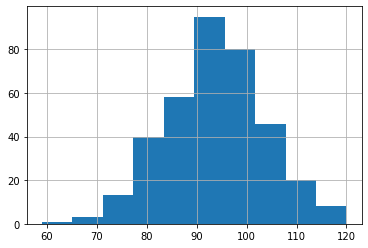

In [26]:
# Визуализируем эти данные
registration_df.groupby('registration_date').merchant_id.count().hist()

Видим, что у нас нормальное распределение, можем дополнительно это проверить. Проверим через тест Агостино-Пирсона, этот тест больше адаптирован к большим выборкам. $H_0$: наблюдения распределены нормально.

In [27]:
ss.normaltest(registration_df.groupby('registration_date').merchant_id.count())

NormaltestResult(statistic=0.7353295412250589, pvalue=0.692349238601581)

In [28]:
# Посмотрим на основные описательные статистики
registration_df.groupby('registration_date').merchant_id.count().describe()

count    364.000000
mean      93.703297
std        9.709266
min       59.000000
25%       88.000000
50%       94.000000
75%      100.000000
max      120.000000
Name: merchant_id, dtype: float64

Среднее кол-во регистраций в день ≈ 94.

## 2.2 Выбор подходящего стат. теста для метрик

Для проверки стат. значимости изменения основной метрики (доля активированных фродеров среди всех активированных юзеров) я бы применила t-тест, так как среднее от 0 и 1 является пропорцией. Лучше применить t-тест Уэлча (добавим параметр `equal_var=False`), так как его результат будет примерно одинаков при равенстве дисперсий в сравнении с t-тестом Стьюдента, а при неравенстве дисперсий t-тест Уэлча отработает лучше, чем t-тест Стьюдента.<br>
Хотелось бы отметить, что t-тест работает и при ненормальных распределениях, о чем говорится в [статье](https://koch-kir.medium.com/%D0%B8%D1%81%D1%82%D0%BE%D1%80%D0%B8%D1%8F-%D0%BE%D0%B4%D0%BD%D0%BE%D0%B3%D0%BE-%D0%BE%D0%B1%D0%BC%D0%B0%D0%BD%D0%B0-%D0%B8%D0%BB%D0%B8-%D1%82%D1%80%D0%B5%D0%B1%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F-%D0%BA-%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8E-%D0%B2-%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85-%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%85-55139a5558d) (нужен VPN).<br>
Также нужно понимать, что t-тест подразумевает независимость отдельных наблюдений, у нас для `ind_frod` это условие соблюдается (все `merchant_id` уникальны, то есть один и тот же `merchant_id` не проходит несколько процедур регистраций, только одну).

Гипотезы для теста:

$H_0$: доля активированных фродеров среди всех активированных юзеров в контрольной и тестовой группе равна.<br>
$H_1$: доля активированных фродеров среди всех активированных юзеров в контрольной и тестовой группе не равна.

Для проверки стат. значимости изменения доп. метрики (среднее кол-во регистраций в день) также подойдет t-тест Уэлча, так как мы будем сравнивать среднее в обеих группах. 

Гипотезы для теста:

$H_0$: среднее кол-во регистраций в день в контрольной и тестовой группе равно.<br>
$H_1$: среднее кол-во регистраций в день в контрольной и тестовой группе не равно.

## 2.3 Уровень значимости (α), мощность (1 - β), длительность, размер выборки и MDE

Уровень значимости (α) = 0.05.

Мощность (1 - β) = 0.8.

Так как мы смотрим на процент фродеров среди всех активированных юзеров, посмотрим, сколько у нас продавцов было активировано в разбивке по каждому дню.

In [29]:
activation_df.groupby('registration_date').merchant_id.count().describe()

count    364.000000
mean      54.387363
std        7.491112
min       28.000000
25%       50.000000
50%       54.000000
75%       60.000000
max       74.000000
Name: merchant_id, dtype: float64

В среднем у нас регистрируются и активируются впоследствии 54 продавца в день (те, кто пройдут полную процедуру регистрации).

Для того чтобы рассчитать размер выборки, необходимо определиться с длительностью эксперимента, будем считать, что тест будет проводиться около 4-х месяцев (а именно 16 недель, 112 дней). 4-х месяцев будет достаточно, чтобы собрать необходимое количество данных, но при этом это не излишне долгий срок. Если уменьшать длительность теста, то MDE будет ниже при заданной α и мощности.

В среднем набирается 54 продавца в день, прошедших полную процедуру регистрации, значит мы можем посчитать размер выборки для каждой группы (контрольной и тестовой).

In [30]:
54 * 112

6048

Размер выборки для каждой группы = 3024 (всего 6048 наблюдений для обеих групп).

Теперь определим MDE, для этого проведем симуляции. Мы хотим понять, как часто мы будем фиксировать стат. значимые различия. Проведем 1000 таких экспериментов, т. е. в цикле 1000 раз проведем t-тест, который будет сравнивать 2 выборки из двух разных распределений (контрольная и тестовая группа).

In [31]:
# Посмотрим на описательные статистики ind_frod в датафрейме только с активированными юзерами
activation_df.ind_frod.describe()

count    19797.000000
mean         0.080770
std          0.272488
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: ind_frod, dtype: float64

In [32]:
mu = 0.080774
sigma = 0.272494
n = 3024
diff = 0.25

In [33]:
n_trials = 1000
significant_count = 0

In [34]:
for i in range(n_trials):
    control_group = np.random.normal(mu, sigma, n)
    exp_group = np.random.normal(mu - mu * diff, sigma, n)
    test_fit = ss.ttest_ind(control_group, exp_group, equal_var=False)
    if test_fit.pvalue < 0.05:
        significant_count += 1

In [35]:
# В каком % случаев наш стат. тест показал стат. значимые различия, т. е. мощность
significant_count / n_trials

0.816

In [36]:
# Посмотрим на значение конверсии, если она уменьшится на 25%, такой MDE мы с большой вероятностью сможем задетектить
(round(mu - mu * diff, 4)) * 100

6.0600000000000005

In [37]:
# Посмотрим на значение конверсии, если она увеличится на 25%, такой MDE мы с большой вероятностью сможем задетектить
(round(mu + mu * diff, 4)) * 100

10.100000000000001

А что если уменьшим MDE до 24%?

In [38]:
mu = 0.080774
sigma = 0.272494
n = 3024
diff = 0.24

In [39]:
n_trials = 1000
significant_count = 0

In [40]:
for i in range(n_trials):
    control_group = np.random.normal(mu, sigma, n)
    exp_group = np.random.normal(mu - mu * diff, sigma, n)
    test_fit = ss.ttest_ind(control_group, exp_group, equal_var=False)
    if test_fit.pvalue < 0.05:
        significant_count += 1

In [41]:
# В каком % случаев наш стат. тест показал стат. значимые различия, т. е. мощность
significant_count / n_trials

0.785

Видим, что мощность уже совсем немного не дотягивает до той, которую мы установили в дизайне эксперимента (0.8).

Можно сказать, что наша разница в 25%, конкретно в этом дизайне эксперимента - это и будет MDE (в относительном выражении), тот размер эффекта, который мы всегда сможем задетектить. Наша выборка в 3024 человека в каждой группе с большой вероятностью позволит зафиксировать различия в 25%. А если бы различия были бы меньше (например, 24%), то уже мощность стат. теста была бы меньше, установленной в дизайне.

В абсолютном выражении MDE ≈ 2%, то есть если наша доля активированных фродеров среди всех активированных юзеров упадет с 8.08% до 6.06% (или вырастет до 10.1%) с большой вероятностью мы это задетектим и это тот мин. детектируемый эффект, который мы обнаружим с заданной мощностью. Будем считать, что если изменение составляет менее 2% в абсолютном выражении, то эксперимент считается неудачным и фичу добавлять не стоит. А вот изменение на 2% для нас уже существенно и нам важно его задетектить.

Можно уменьшить длительность теста (4 месяца - это крайний предел для длительности, по моему мнению), но тогда нужно понимать, что MDE будет уже выше при заданной α и мощности. Тут уже вопрос приоритетов, что нам важнее: быстрее провести тест или с большой вероятностью словить тот MDE, который для нас будет существенен.

Также можно еще попробовать прибегнуть к методам, позволяющим увеличивать мощность (снижать дисперсию) в A/B-тестах, таким как CUPED, постнормировка и стратификация.

## 2.4 Разбиение на группы и А/А-тест

В рамках A/B-теста мы будем всех продавцов распределять случайным образом делить на две равные группы: тестовую (50%) и контрольную группу (50%).

На имеющихся исторических данных проведем A/A-тестирование. Таким способом мы:
- проверим, насколько наши данные подвержены отклонениям, не связанным с проведением A/B-теста
- совершим те же самые действия, которые мы потом будем совершать при проведении настоящего A/B теста

Проведем предварительный набор A/A-тестов с расчетом p-value, которое в случае корректности сплитования и выбора критериев будет распределено равномерно.

Берем `activation_df` так как для расчета основной метрики нам нужно посчитать долю фродеров среди именно активированных юзеров.

In [42]:
sample_size = 3024
p_values = []

for i in range(10000):
    control = activation_df.sample(sample_size).ind_frod
    test = activation_df.drop(control.index).sample(sample_size).ind_frod
    result = ss.ttest_ind(control, test, equal_var=False)
    p_value = result.pvalue
    p_values.append(p_value)

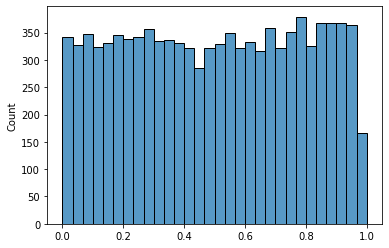

In [43]:
sns.histplot(p_values, bins=30)

In [44]:
round(((np.array(p_values) <= 0.05).mean()) * 100, 5)

4.97

В t-тесте p-value оказалось меньше либо равно 0.05 в 4.97% случаев. Видно, что вероятность ошибки 1-го рода контролируется.

# 3. Ответы на вопросы

## Как определить, какой продавец мошенник, а какой — нет?

- Для того чтобы определить мошенника можно во время регистрации ввести произведение звонка на привязанный номер и ввод последних 4 цифр входящего номера продавцом. Мошенники не хотят светить свои номера телефонов, поэтому могут покупать онлайн-номера. Используя его можно принять сообщение с кодом и подтвердить регистрацию, но именно звонок не пройдет по такой схеме.
- Если продавец регистрирует несколько магазинов с одного IP-адреса, то, возможно, что он фродер и это делает массово, необходимо заблокировать доступ с такого IP-адреса.
- С помощью фото паспорта можно будет идентифицировать ФИО мерчанта, они должны совпадать с ФИО в зарегистрированном ИНН. Также можно будет дополнительно проверить адрес регистрации, если говорим об ИП. Юридический адрес ИП — это адрес регистрации продавца, по которому он прописан. Этот адрес можно посмотреть в паспорте на отдельной странице.
- Нужно проверить расчетный счет, он должен принадлежать ИП.
- Можно ввести обязательным этапом предоставление справки о системе налогообложения, как доказательство того, что у продавца действительно есть ИП и именно его он пытается зарегистрировать на маркетплейсе. Справка формируется в ЛК налогоплательщика. Либо скриншот из ЛК, как подтверждение того, что это честный продавец, не фродер.
- Можно также проверить код ОКВЭД и его соответствие товарам продавца.
- Также можно запросить документы на товары, но нужно понимать, что они легко подделываются.

Еще можно задетектить фродера по след. признакам (уже после его активации):
- Описание в карточке товара. Если описания нет, оно короткое или слишком общее и при этом цена товара ниже, чем в других предложениях, это должно вызвать подозрения насчет фрода.
- Частые отмены заказов именно по желанию покупателя, то есть покупатель скорее всего отменяет заказ на площадке, чтобы оплатить его через сторонние сервисы. Или же отмены со стороны продавца (продавец сам отменяет заказ и пишет покупателю в личку).
- Отсутствие продаж с момента активации. Возможно, что идут "фейковые" мошеннические продажи не на площадке, нужно через какое-то время деактивировать аккаунт, если продавец зашел на площадку, но так ничего и не продал.
- Отсутствие отзывов. Соответственно, если нет продаж на площадке, то отзывов тоже не будет.

## Какие ещё могут быть схемы мошенничества?

- Продажа неоригинальных товаров под видом оригинальных и по цене оригинальных.
- Продажа подменных товаров. Продавец-фродер берёт известный бренд и заводит на маркетплейсе магазин с таким названием. Но в итоге продает совсем не то, что заявлено на странице маркетплейса.
- Кража личных данных через спам-звонок. Фродер звонит человеку, представляется сотрудником маркетплейса и просит подтвердить данные о доставке, ссылаясь на стандартную процедуру. Этой схемой можно выманить у покупателей логины и пароли от учётных записей.
- Покупатель оформляет заказ и через несколько минут продавец-фродер нажимает кнопку о том, что заказ доставлен, а покупатель получает пуш с уведомлением об успешной доставке. При доставке DBS (Delivery By Seller) продавец может нажать кнопку "заказ доставлен" в любое время. То есть покупатель все оплатил, но по факту ничего не получил. Можно ввести штраф для продавца, если он нажал эту кнопку раньше указанной даты. Но здесь все произошло на площадке, а не во вне, поэтому маркетплейс должен разобраться в этой ситуации и вернуть деньги покупателю.

## Какие продуктовые фичи могут помочь нашим клиентам избежать неприятных ситуаций с мошенничеством?

- Всплывающий баннер/сторис в приложении/на сайте о частых схемах фрода, чтобы повысить информированность покупателей о мошенничестве.
- Ввести рейтинг продавца.
- Отсутствие возможности у продавца установить цену на товар сильно ниже рыночной, так товар фродера уже не будет таким привлекательным для покупателя на фоне других. Единственный плюс товара у фродера по сравнению с тем же товаром у других продавцов - это цена.
- Можно сделать плашку на товаре - "цена сильно ниже/выше рынка" (для товаров с заниженной или завышенной ценой). Покупатель, возможно, посчитает такой товар и продавца подозрительными.
- Также можно ввести платный вход на площадку, фродеры с меньшей вероятностью будут регистрироваться на площадке, если есть платный вход. Чем проще вход на площадку, тем лучше для фродера. Не совсем продуктовая фича, больше как просто способ снизить кол-во продавцов-фродеров.

## Через какую механику мошенник узнает контакты покупателя? Что можем сделать, чтобы усложнить жизнь фродерам?

- Когда покупатель делает заказ у продавца, то ему могут быть видны перс. данные покупателя - фамилия и имя, телефон, email, адрес доставки (дом. адрес, если доставка курьером). В частности они могут становиться видны продавцу при оформлении заказа покупателем. В таком случае у продавца в ЛК появляется этикетка отправки и акт, в них могут быть перс. данные, которые фродер может потом использовать в своих целях. Также если на этикетке есть только фамилия и имя + адрес, то фродер может пробить телефон по слитым базам данных. Даже если указан только адрес ПВЗ, из-за того, что покупатели обычно выбирают ПВЗ рядом с домом, есть вероятность, что по улице ПВЗ все равно можно идентифицировать адрес проживания. Нужно эти перс. данные покупателя обезличить и идентифицировать посылку только, например, по QR-коду и номеру посылки, а покупателя никак не идентифицировать.
- Фродеры могут оставить в описании товара номер телефона и они просят перед оформлением заказа обязательно написать менеджеру. Так покупатель может написать по номеру, предложенному в описании товара и сам слить свои данные. Также такое может происходить и в чате продавца с покупателем, продавец может попросить покупателя перейти на сторонний ресурс. Соответственно, нужно блокировать профили с номерами телефонов и с похожими сообщениями в чате, любыми ссылками, названиями магазинов, куда покупатель может сам перейти.